# Final Project
---

#### By: Chris Vaisnor

# System Setup
- OS: Ubuntu 22.04.2 LTS
- Python Version: 3.10.12

In [27]:
import os
import torch
import torchvision
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms

cudnn.benchmark = True
plt.ion() # interactive mode

In [28]:
print('PyTorch Version: ', torch.__version__)
print('CUDA Available: ', torch.cuda.is_available())
print('Device Type: ', torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch Version:  2.1.0+cu121
CUDA Available:  True
Device Type:  NVIDIA GeForce RTX 4090


# Dataset Class

In [29]:
class MinecraftImageClassification(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(self.root_dir)
        self.filenames = []
        self.class_indices = []

        for class_index, dataset_class in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, dataset_class)
            class_filenames = os.listdir(class_dir)

            self.filenames += list(map(lambda x: os.path.join(class_dir, x), class_filenames))
            self.class_indices += [class_index]*len(class_filenames)

        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        class_index = self.class_indices[idx]

        if self.transform:
            image = self.transform(image)

        return image, class_index

# Data Loading and Transformations

- The frames in the data are currently sized at 1920 x 1080.
- The ResNet family of models requires the input to be of maximum size 224 x 224.
    - `transforms.RandomResizedCrop(224)` will be used to crop the frames to the required size using a random portion of the frame.
    - `transforms.ToTensor()` will be used to convert the frames to a tensor.
    - `transforms.Normalize()` will be used to normalize the frames according to the requirements of the ResNet models.
        - https://pytorch.org/hub/pytorch_vision_resnet/

In [30]:
# transformations for the training images based on ResNet normalization requirements https://pytorch.org/hub/pytorch_vision_resnet/
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MinecraftImageClassification(root_dir='frames_biomes/train', transform=transform)
test_dataset = MinecraftImageClassification(root_dir='frames_biomes/test', transform=transform)

# info about the datasets
print('Train dataset size: ', len(train_dataset))
print('Test dataset size: ', len(test_dataset))
print('Number of classes: ', len(train_dataset.classes))

Train dataset size:  1600
Test dataset size:  400
Number of classes:  10


### Small function to show the one frame from each class in the dataset.

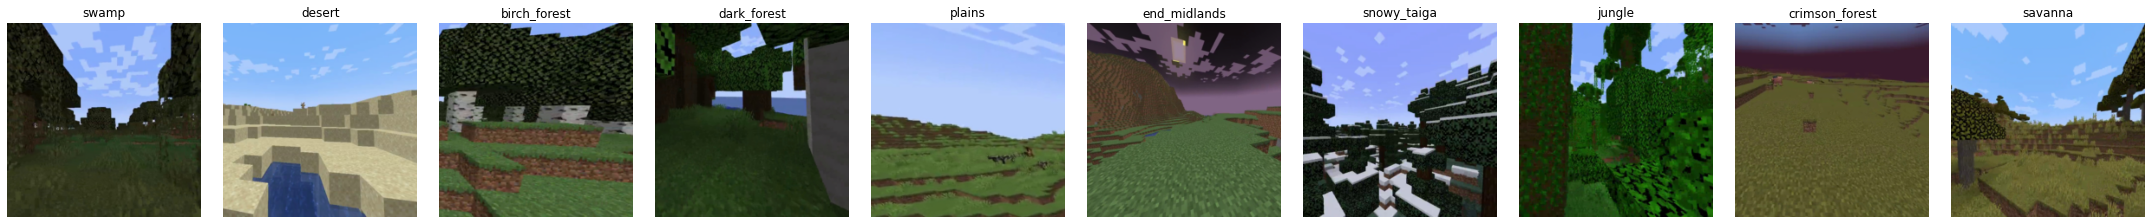

In [31]:
def show_images(dataset):
    num_classes = len(dataset.classes)
    fig, axs = plt.subplots(1, num_classes, figsize=(3*num_classes, 3), constrained_layout=True)

    for i, dataset_class in enumerate(dataset.classes):
        class_idx = dataset.class_indices.index(i)
        image, _ = dataset[class_idx]
        
        # if the dataset has 'transform' attribute and it is not None
        if getattr(dataset, "transform") and dataset.transform is not None:
            # unnormalize images for display
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image.permute(1,2,0).numpy() + mean
            image = np.clip(image, 0, 1)
        
        axs[i].imshow(image)
        axs[i].set_title(dataset_class)
        axs[i].axis('off')
    plt.show()

show_images(train_dataset)

# Preparing Data For the Model

In [32]:
from torch.utils.data import DataLoader, random_split

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

# ensure the randomness of the splitting process different every time you run the code
torch.manual_seed(0) 

train_dataset_split, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32 # this value can be changed depending on the available memory

train_loader = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Train dataloader size: ', len(train_loader))
print('Validation dataloader size: ', len(val_loader))
print('Test dataloader size: ', len(test_loader))

Train dataloader size:  40
Validation dataloader size:  10
Test dataloader size:  13


# Initializing the Model

- ResNet18 is used as the base model.
    - Using larger models like ResNet50 or ResNet152 requires more computational resources and time
    - ResNet18 provides the fastest runtime while still providing accuracy in the 95%+ range.

In [33]:
from torchvision.models.resnet import ResNet18_Weights
# from torchvision.models.resnet import ResNet152_Weights
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# model = models.resnet152(weights=ResNet152_Weights)

# Modifications For Transfer Learning

In [34]:
# get the number of input features to the last layer
n_inputs = model.fc.in_features 

# redefine the last layer (fully connected layer) to match the number of classes in our dataset
model.fc = nn.Linear(n_inputs, num_classes)

model = model.to(device)

# Criterion, Optimizer, and Scheduler

In [35]:
# Cross-entropy Loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Model Summary

In [36]:
from torchsummary import summary

summary_output = summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

# Train and Test Functions

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # save the model
    torch.save(model.state_dict(), 'minecraft_biomes_resnet18.pth')

    return model

# def test_model(model):
#     model.eval()   # Set model to evaluation mode

#     running_corrects = 0

#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         with torch.no_grad():
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
                        
#         running_corrects += torch.sum(preds == labels.data)
            
#     acc = running_corrects.double() / len(test_loader.dataset)

#     print('Test Acc: {:.4f}'.format(acc))


def evaluate_model(model):
    model.eval()   # Set model to evaluation mode

    y_true = []
    y_pred = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        y_true += labels.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=test_dataset.classes)

    print('Test Acc: {:.4f}'.format(acc))
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

    # graph 5 random test images with their predicted and true labels
    fig, axs = plt.subplots(1, num_classes, figsize=(25, 5), constrained_layout=True)
    for i in range(num_classes):
        idx = np.random.randint(0, len(test_loader.dataset))
        inputs, labels = test_loader.dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # unnormalize images for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inputs = std * inputs.squeeze().permute(1,2,0).cpu().numpy() + mean
        inputs = np.clip(inputs, 0, 1)

        axs[i].imshow(inputs)
        axs[i].set_title('Predicted: {}\nActual: {}'.format(test_dataset.classes[preds.item()], test_dataset.classes[labels]))
        axs[i].axis('off')

    plt.show()

# Training the Model

In [41]:
trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)


Epoch 0/4


100%|██████████| 40/40 [00:10<00:00,  3.88it/s]


train Loss: 0.1553 Acc: 0.9797


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


val Loss: 0.1229 Acc: 0.9875

Epoch 1/4


100%|██████████| 40/40 [00:10<00:00,  3.93it/s]


train Loss: 0.1770 Acc: 0.9758


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


val Loss: 0.1083 Acc: 0.9875

Epoch 2/4


100%|██████████| 40/40 [00:10<00:00,  3.96it/s]


train Loss: 0.1565 Acc: 0.9789


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


val Loss: 0.1327 Acc: 0.9781

Epoch 3/4


100%|██████████| 40/40 [00:09<00:00,  4.08it/s]


train Loss: 0.1610 Acc: 0.9828


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


val Loss: 0.1016 Acc: 0.9906

Epoch 4/4


100%|██████████| 40/40 [00:10<00:00,  3.90it/s]


train Loss: 0.1590 Acc: 0.9828


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

val Loss: 0.1272 Acc: 0.9719
Best val Acc: 0.990625


# Testing the Model

Test Acc: 0.9750
Confusion Matrix:
[[40  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  2  0  0  0  0]
 [ 0  0  0 40  0  0  0  0  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0]
 [ 0  0  1  3  0  0 36  0  0  0]
 [ 0  0  0  2  0  0  0 38  0  0]
 [ 0  0  0  0  0  1  0  0 38  1]
 [ 0  0  0  0  0  0  0  0  0 40]]
Classification Report:
                precision    recall  f1-score   support

         swamp       1.00      1.00      1.00        40
        desert       1.00      1.00      1.00        40
  birch_forest       0.97      0.95      0.96        40
   dark_forest       0.89      1.00      0.94        40
        plains       1.00      1.00      1.00        40
  end_midlands       0.93      1.00      0.96        40
   snowy_taiga       1.00      0.90      0.95        40
        jungle       1.00      0.95      0.97        40
crimson_forest       1.00      0.95      0.97        40
       savanna       0.98      1.00      0.99     

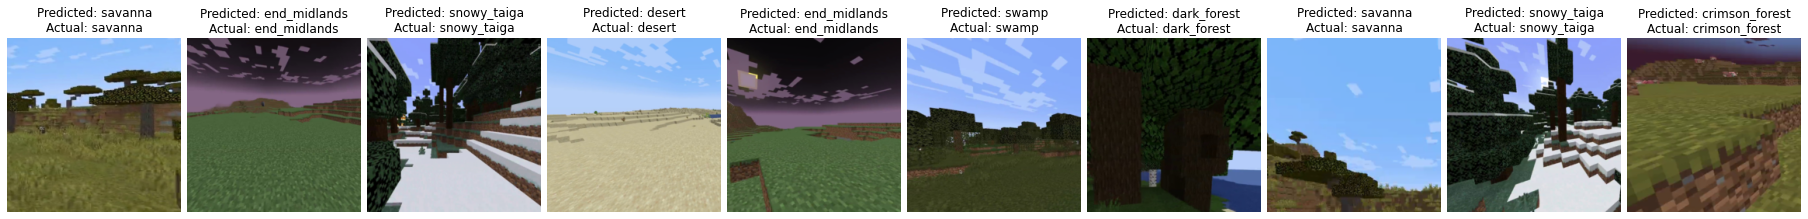

In [42]:
evaluate_model(trained_model)

# Success!